# Electricity Price Forecasting

## Goals
* explore seasonality and trends in electricity prices and revenue
* build models to forecast electricity prices
* Bring in external data to complement historical price data

In [111]:
pip install meteostat

Note: you may need to restart the kernel to use updated packages.


In [112]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [113]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error
from meteostat import Monthly, Point
from sklearn.preprocessing import MinMaxScaler


In [114]:
path = '/kaggle/input/electricity-prices/clean_data.csv'
df = pd.read_csv(path)
df.head()

,year,month,stateDescription,sectorName,customers,price,revenue,sales
0,2001,1,Wyoming,all sectors,NaN,4.31,48.12840,1116.17208
1,2001,1,Wyoming,commercial,NaN,5.13,12.67978,247.08691
2,2001,1,Wyoming,industrial,NaN,3.26,19.60858,602.30484
3,2001,1,Wyoming,other,NaN,4.75,0.76868,16.17442
4,2001,1,Wyoming,residential,NaN,6.01,15.07136,250.60591


## Exploratory Data Analysis

* Univariate Analysis
* Covariate analyis
* Time series visualization
* Time series decomposition

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85870 entries, 0 to 85869
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              85870 non-null  int64  
 1   month             85870 non-null  int64  
 2   stateDescription  85870 non-null  object 
 3   sectorName        85870 non-null  object 
 4   customers         59830 non-null  float64
 5   price             85870 non-null  float64
 6   revenue           85870 non-null  float64
 7   sales             85870 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 5.2+ MB


In [116]:
df.describe()

,year,month,customers,price,revenue,sales
count,85870.000000,85870.000000,5.983000e+04,85870.000000,85870.000000,85870.000000
mean,2012.043321,6.480144,2.916013e+06,9.300193,586.627155,5980.048970
std,6.660304,3.461589,1.200567e+07,5.010382,2161.047702,21302.453181
min,2001.000000,1.000000,0.000000e+00,0.000000,-0.000010,0.000000
25%,2006.000000,3.000000,4.998000e+03,6.650000,29.475195,289.144572
50%,2012.000000,6.000000,2.997540e+05,8.840000,121.641500,1447.518085
75%,2018.000000,9.000000,2.028716e+06,11.380000,421.320628,4339.950965
max,2024.000000,12.000000,1.625050e+08,116.670000,52361.450970,391900.008970


### To do
* Check if there is data from each month from January 2001 to 2024
* Visualize

### Univariate Analysis

In [117]:
df['sectorName'].value_counts()

sectorName
all sectors       17174
commercial        17174
industrial        17174
residential       17174
transportation    15686
other              1488
Name: count, dtype: int64

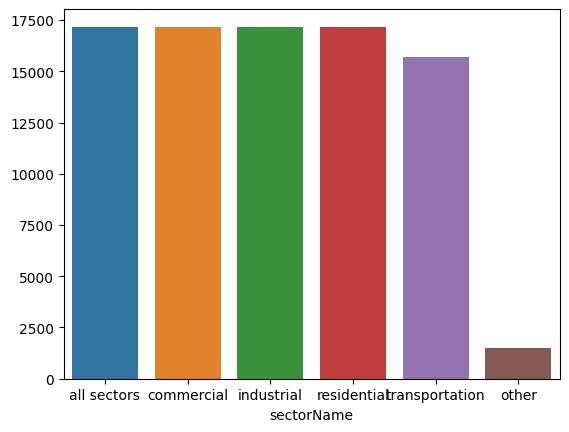

In [118]:
sns.barplot(x = df['sectorName'].value_counts().index, y = df['sectorName'].value_counts().values)
plt.show()

In [119]:
df['stateDescription'].value_counts()

stateDescription
Wyoming          1385
Kansas           1385
North Dakota     1385
Ohio             1385
Oklahoma         1385
                 ... 
Montana          1385
Nebraska         1385
Nevada           1385
New Hampshire    1385
Pennsylvania     1385
Name: count, Length: 62, dtype: int64

In [120]:
df['stateDescription'].unique()

array(['Wyoming', 'New England', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Alabama', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Middle Atlantic', 'Pacific Contiguous',
       'Pacific Noncontiguous', 'U.S. Total', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Rhode Island', 'Alaska', 'Arizona', 'Georgia', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'East North Central',
       'West North Central', 'South Atlantic', 'East South Central',
       'West South Central', 'Mountain', 'Pennsylvania'], dtype=object)

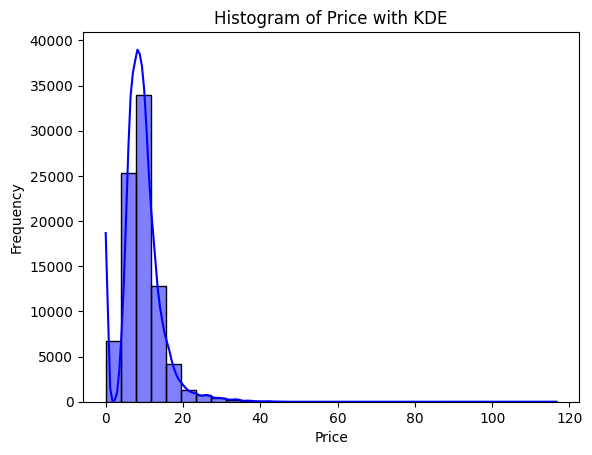

In [121]:
sns.histplot(df['price'], bins=30, kde=True, color='blue')

# Add labels and title
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Histogram of Price with KDE")

# Show the plot
plt.show()

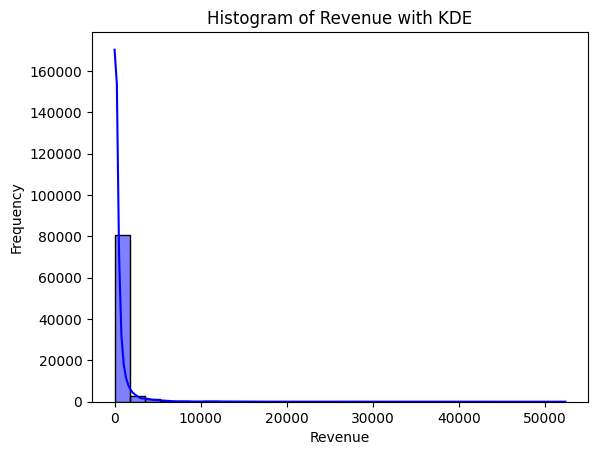

In [122]:
sns.histplot(df['revenue'], bins=30, kde=True, color='blue')

# Add labels and title
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.title("Histogram of Revenue with KDE")

# Show the plot
plt.show()

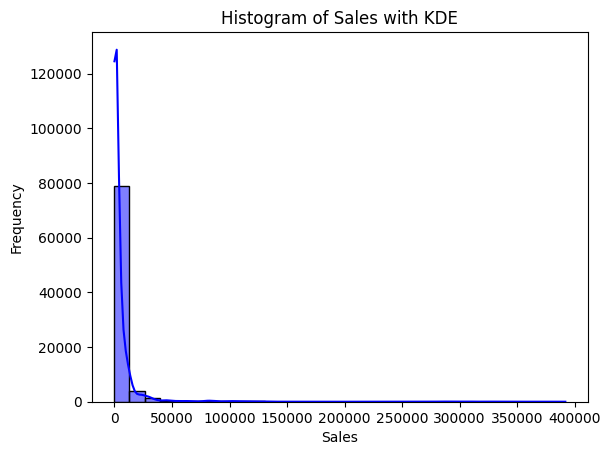

In [123]:
sns.histplot(df['sales'], bins=30, kde=True, color='blue')

# Add labels and title
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.title("Histogram of Sales with KDE")

# Show the plot
plt.show()

In [124]:
df['customers'].isna().value_counts()

customers
False    59830
True     26040
Name: count, dtype: int64

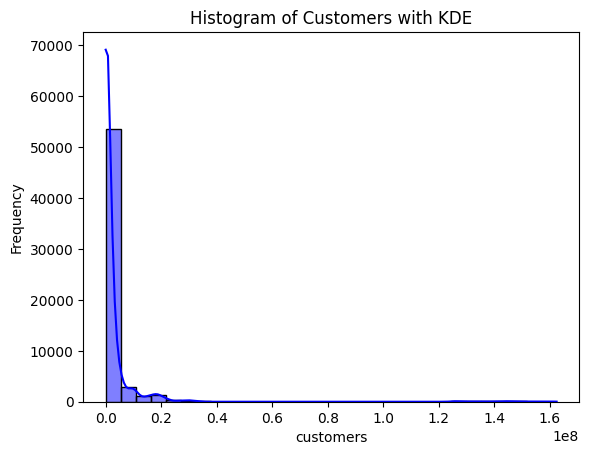

In [125]:
sns.histplot(df['customers'], bins=30, kde=True, color='blue')

# Add labels and title
plt.xlabel("customers")
plt.ylabel("Frequency")
plt.title("Histogram of Customers with KDE")

# Show the plot
plt.show()

### Covariate Analysis

In [126]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

In [127]:
df.groupby('year')[['price', 'sales', 'revenue']].mean()

,price,sales,revenue
year,,,
2001,7.621320,5474.932426,398.940476
2002,7.455519,5589.461308,402.275018
2003,6.569715,5635.055623,418.978795
2004,6.902169,5721.741102,435.676171
2005,7.562704,5904.787924,480.649711
2006,8.253118,5919.223935,526.622527
2007,8.497567,6071.872116,554.358966
2008,9.258411,6022.523580,586.424373
2009,9.103656,5801.282475,569.821393


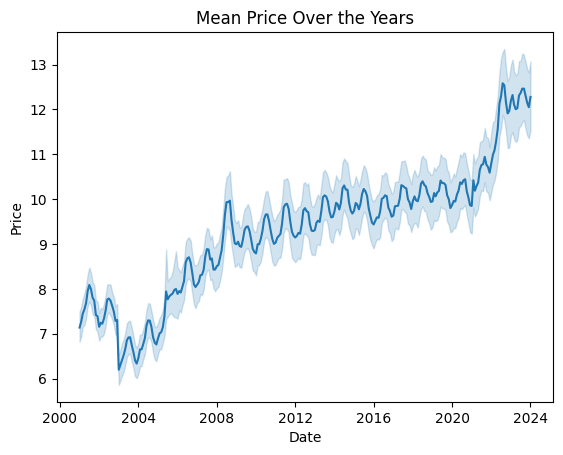

In [128]:
sns.lineplot(data=df, x='date', y='price')

# Customize plot
plt.title('Mean Price Over the Years')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

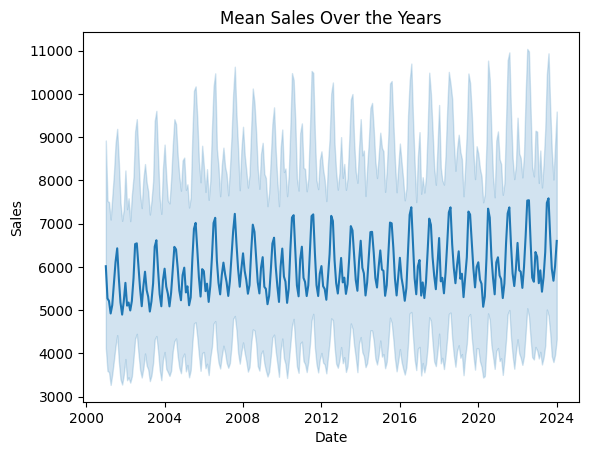

In [129]:
sns.lineplot(data=df, x='date', y='sales')

# Customize plot
plt.title('Mean Sales Over the Years')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

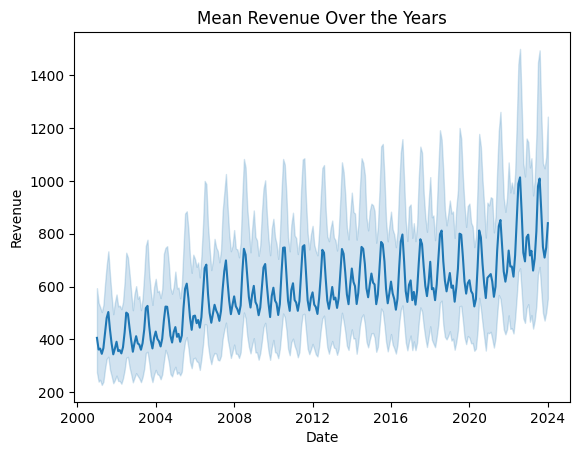

In [130]:
ax = sns.lineplot(data=df, x='date', y='revenue')

# Customize plot
plt.title('Mean Revenue Over the Years')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.show()

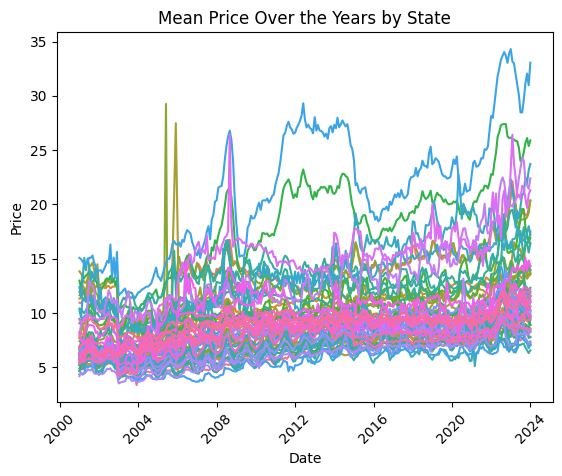

In [131]:
ax = sns.lineplot(data=df, x='date', y='price', hue='stateDescription', errorbar=None, legend=None)
#sns.move_legend(ax, "lower left")
# Customize plot
plt.title('Mean Price Over the Years by State')
plt.xlabel('Date')
plt.ylabel('Price')
#plt.legend(title='State', location='bottom')
plt.xticks(rotation=45) 
plt.show()

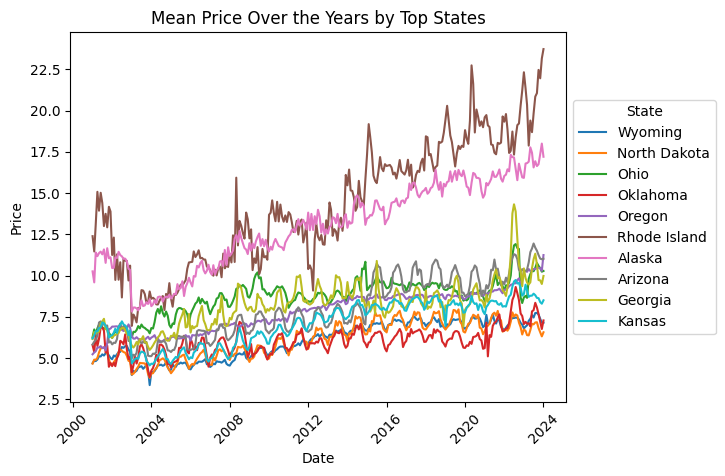

In [132]:
# Sort or select the top states based on frequency, for example:
top_states = df['stateDescription'].value_counts().head(10).index
df_top_states = df[df['stateDescription'].isin(top_states)]

ax = sns.lineplot(data=df_top_states, x='date', y='price', hue='stateDescription', errorbar=None)

# Move the legend to the lower-left position
sns.move_legend(ax, "lower left")

# Customize plot
plt.title('Mean Price Over the Years by Top States')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(title='State', loc='center left', bbox_to_anchor=(1, 0.5))  # Move the legend outside
plt.xticks(rotation=45)
plt.show()

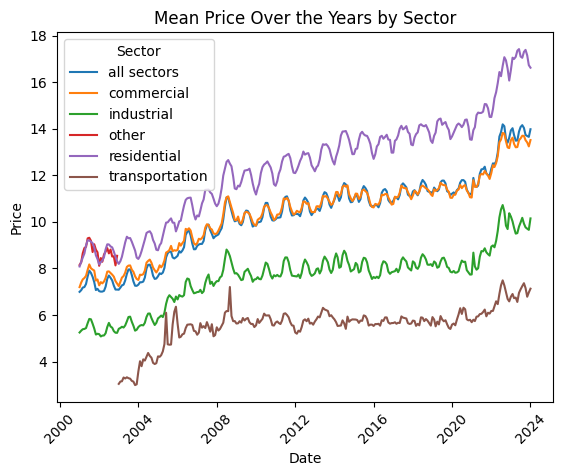

In [133]:
sns.lineplot(data=df, x='date', y='price', hue='sectorName', errorbar=None)

# Customize plot
plt.title('Mean Price Over the Years by Sector')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(title='Sector')
plt.xticks(rotation=45) 
plt.show()

### Price distribution per sector

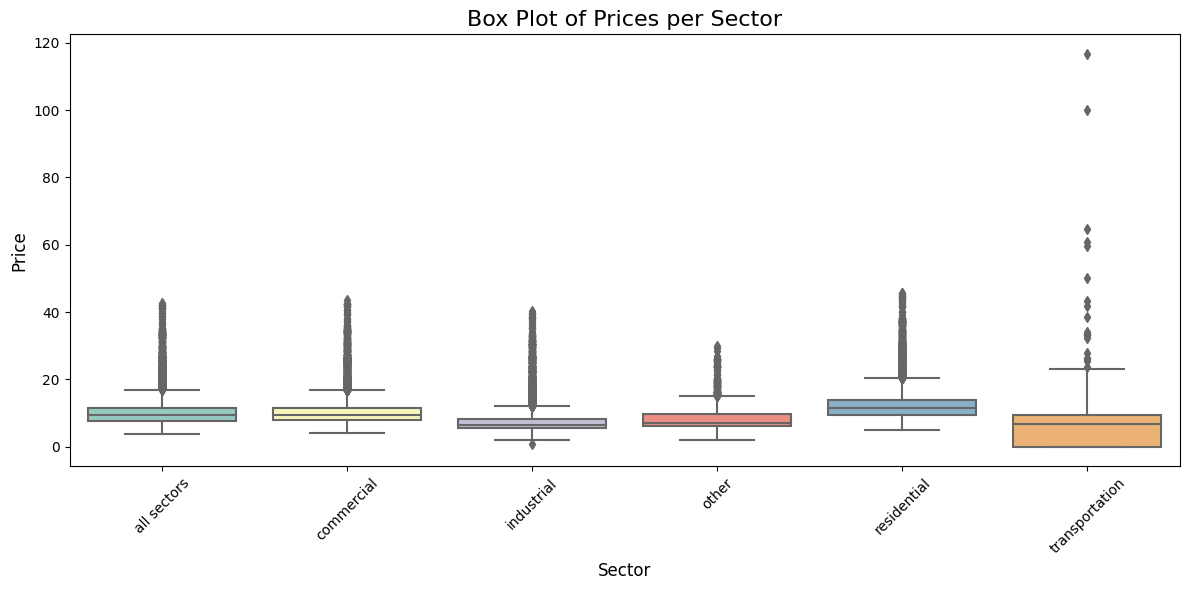

In [134]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='sectorName', y='price', palette='Set3')

# Customize the plot
plt.title('Box Plot of Prices per Sector', fontsize=16)
plt.xlabel('Sector', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary

# Show the plot
plt.tight_layout()
plt.show()

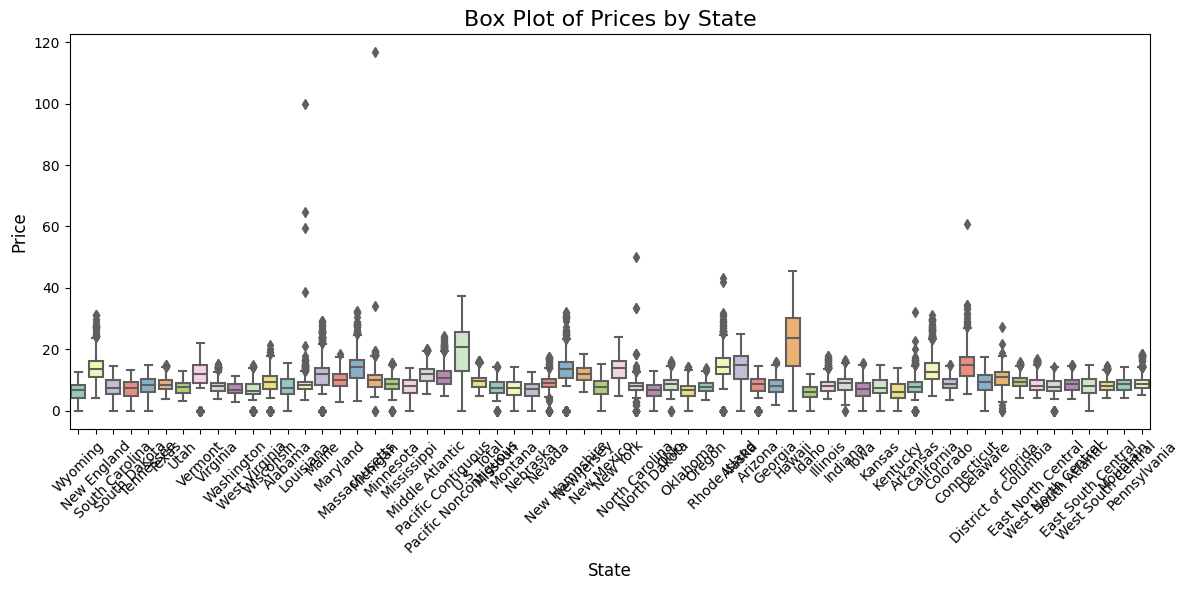

In [135]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='stateDescription', y='price', palette='Set3')

# Customize the plot
plt.title('Box Plot of Prices by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary

# Show the plot
plt.tight_layout()
plt.show()

### Seasonal Decomposition

## For New York and the residential sector

In [136]:
df.set_index('date', inplace=True)

In [137]:
df_ny_residential = df[df['stateDescription']=='New York']
df_ny_residential = df_ny_residential[df_ny_residential['sectorName']=='residential']

In [138]:
df_ny_residential

,year,month,stateDescription,sectorName,customers,price,revenue,sales
date,,,,,,,,
2001-01-01,2001,1,New York,residential,NaN,13.89,579.86655,4175.33424
2001-02-01,2001,2,New York,residential,NaN,13.93,515.75364,3701.67426
2001-03-01,2001,3,New York,residential,NaN,13.58,500.04422,3682.95767
2001-04-01,2001,4,New York,residential,NaN,13.44,437.00018,3251.18097
2001-05-01,2001,5,New York,residential,NaN,14.01,432.91117,3090.92043
...,...,...,...,...,...,...,...,...
2023-09-01,2023,9,New York,residential,7393254.0,23.33,1080.07776,4629.23183
2023-10-01,2023,10,New York,residential,7390536.0,22.06,806.60309,3656.21194
2023-11-01,2023,11,New York,residential,7398579.0,22.95,829.26306,3614.03277


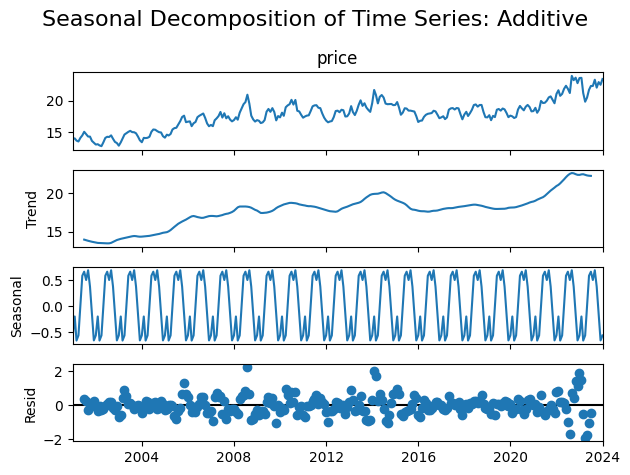

In [139]:
# Perform seasonal decomposition: additive
result = seasonal_decompose(df_ny_residential['price'], model='additive', period=12)  # 'period' is the seasonal cycle length

# Plot the components
result.plot()
plt.suptitle('Seasonal Decomposition of Time Series: Additive', fontsize=16)
plt.tight_layout()
plt.show()

# Access components programmatically
trend = result.trend
seasonal = result.seasonal
residual = result.resid

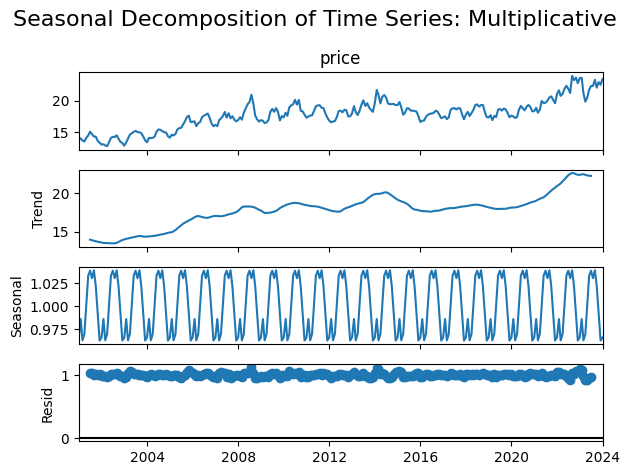

In [140]:
# Perform seasonal decomposition: additive
result = seasonal_decompose(df_ny_residential['price'], model='multiplicative', period=12)  # 'period' is the seasonal cycle length

# Plot the components
result.plot()
plt.suptitle('Seasonal Decomposition of Time Series: Multiplicative', fontsize=16)
plt.tight_layout()
plt.show()

# Access components programmatically
trend = result.trend
seasonal = result.seasonal
residual = result.resid

### The additive decomposition is better since residuals are more normally distributed

In [141]:
## add trend amd seasonal decomposition as features to dataframe
df_ny_residential['seasonal']= result.seasonal
df_ny_residential['trend']= result.trend

### Create Lag Features

In [142]:
# Create lag features
df_ny_residential['lag1'] = df_ny_residential['price'].shift(1)
df_ny_residential['lag7'] = df_ny_residential['price'].shift(7)

## Moving Averages

### Calculate moving averages

In [143]:
## 7-day Simple moving average
sma_window = 7  # 7-day moving average
sma = df_ny_residential['price'].rolling(window=sma_window).mean()
## 30-day Exponential moving average
ema_window = 30  # 30-day moving average
ema = df_ny_residential['price'].ewm(span=ema_window, adjust=False).mean()

### Plot moving averages

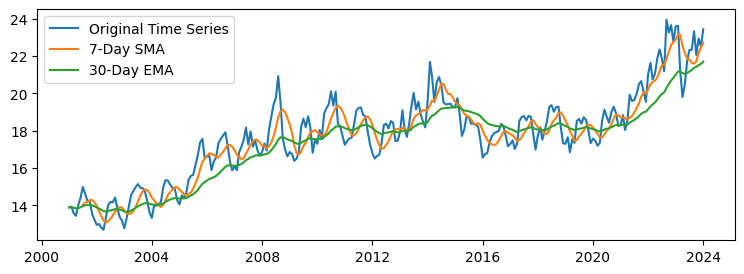

In [144]:
plt.figure(figsize=(9, 3))
plt.plot(df_ny_residential['price'], label='Original Time Series')
plt.plot(sma, label=f'{sma_window}-Day SMA')
plt.plot(ema, label=f'{ema_window}-Day EMA')
plt.legend()
plt.show()

### Add moving averages as features¶

In [145]:
df_ny_residential['rolling_avg_7'] = sma
df_ny_residential['exp_moving_avg_30'] = ema

### Outlier Detection

### Looking a z-score>3

In [146]:
df_ny_residential['z_score'] = zscore(df_ny_residential['price'])
outliers = df_ny_residential[abs(df_ny_residential['z_score']) > 3]

In [147]:
print(outliers)

Empty DataFrame
Columns: [year, month, stateDescription, sectorName, customers, price, revenue, sales, seasonal, trend, lag1, lag7, rolling_avg_7, exp_moving_avg_30, z_score]
Index: []


## There are no observations such that z-score>3,looking at z-score>2

In [148]:
outliers2 = df_ny_residential[abs(df_ny_residential['z_score']) > 2]
outliers2

,year,month,stateDescription,sectorName,customers,price,revenue,sales,seasonal,trend,lag1,lag7,rolling_avg_7,exp_moving_avg_30,z_score
date,,,,,,,,,,,,,,,
2002-01-01,2002,1,New York,residential,NaN,12.95,528.17566,4077.94117,0.965665,13.599167,13.25,14.41,13.968571,13.886095,-2.032647
2002-02-01,2002,2,New York,residential,NaN,13.00,468.14273,3601.79329,0.985901,13.547083,12.95,14.99,13.684286,13.828927,-2.011414
2002-03-01,2002,3,New York,residential,NaN,12.81,451.94510,3527.31783,0.962637,13.536250,13.00,14.61,13.427143,13.763190,-2.092099
2002-04-01,2002,4,New York,residential,NaN,12.69,422.40782,3329.31039,0.969564,13.529583,12.81,14.23,13.207143,13.693952,-2.143058
2003-01-01,2003,1,New York,residential,NaN,12.77,566.16779,4432.82071,0.965665,13.996250,13.19,14.01,13.710000,13.671676,-2.109085
2022-09-01,2022,9,New York,residential,7336278.0,23.95,1166.84000,4871.89367,1.039024,22.517917,21.20,21.64,21.865714,20.301513,2.638572
2022-10-01,2022,10,New York,residential,7384092.0,23.26,826.05839,3550.87459,1.021523,22.484583,23.95,20.75,22.224286,20.492383,2.345559
2022-11-01,2022,11,New York,residential,7400113.0,23.66,815.80471,3448.43457,0.990901,22.374583,23.26,21.06,22.595714,20.696745,2.515421
2022-12-01,2022,12,New York,residential,7370759.0,22.78,964.72750,4234.46457,0.962397,22.289583,23.66,21.86,22.727143,20.831149,2.141724


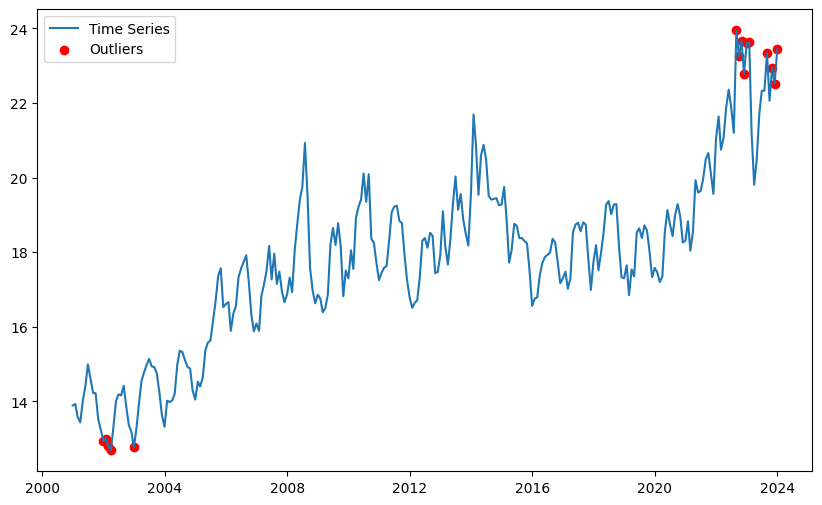

In [149]:
plt.figure(figsize=(10, 6))
plt.plot(df_ny_residential.index, df_ny_residential['price'], label='Time Series')
plt.scatter(outliers2.index, outliers2['price'], color='red', label='Outliers')
plt.legend()
plt.show()

#### The outliers occur in 2002-2003, 2022 and 2023-2024. 

### Normalize data

## Bringing in External Data: Electricity prices depend on
* Cost of Generation: Fuel costs and costs from investment in renewable energy sources
* Seasonality and Weather Conditions
* Population Growth and Urbanization
* Regulatory and Policy Factors such as Government Subsidies for renewable energy or residential consumption
* Market and Economics Factors such as Inflation and unemployment

### Bring in Weather Data

In [150]:
start = dt.datetime(2001, 1, 1)
end = dt.datetime(2024, 12, 31)
nyc = Point(40.7128, -74.0060)  # NYC coordinates
data = Monthly(nyc, start, end)
weather_data = data.fetch()

In [151]:
weather_data.head()

,tavg,tmin,tmax,prcp,wspd,pres,tsun
time,,,,,,,
2001-01-01,0.2,-3.6,3.9,65.4,14.7,1016.4,NaN
2001-02-01,2.2,-2.3,6.5,45.6,18.0,1021.1,NaN
2001-03-01,4.6,0.7,8.1,169.9,19.6,NaN,NaN
2001-04-01,12.0,6.6,17.1,43.3,15.1,NaN,NaN
2001-05-01,17.9,12.7,22.9,73.3,15.7,1016.7,NaN


tsun: total sunlight duration

#### Fill in missing weather data

In [152]:
weather_data.fillna(method='ffill', inplace=True)

In [153]:
weather_data_train = weather_data[weather_data.index.year<2015]
weather_data_test = weather_data[(weather_data.index.year>=2015) & (weather_data.index.year<2020)]

### Normalize weather data

In [154]:
scaler = MinMaxScaler()

Normalize

In [155]:
normalized_weather_train = pd.DataFrame(scaler.fit_transform(weather_data_train), 
                                        columns = weather_data_train.columns,
                                       index = weather_data_train.index)
normalized_weather_test = pd.DataFrame(scaler.fit_transform(weather_data_test), 
                                        columns = weather_data_test.columns,
                                       index = weather_data_test.index)

## Bring in Macroeconomic Data
Source: FRED

In [156]:
pop_data_path = '/kaggle/input/new-york-population/NYPOP.csv'
hh_income_data_path = '/kaggle/input/real-median-household-income-in-new-york/MEHOINUSNYA672N.csv'

population_data = pd.read_csv(pop_data_path)
hh_income_data = pd.read_csv(hh_income_data_path)

In [157]:
## join by date:
macroecon_data = population_data.merge(hh_income_data, how = 'inner', on = 'observation_date')

In [158]:
macroecon_data = macroecon_data.rename(columns = {'NYPOP': 'ny_population', 'MEHOINUSNYA672N': 'ny_median_hh_income'})
macroecon_data

,observation_date,ny_population,ny_median_hh_income
0,2000-01-01,19001.780,67950
1,2001-01-01,19082.838,68680
2,2002-01-01,19137.800,67600
3,2003-01-01,19175.939,67520
4,2004-01-01,19171.567,68730
5,2005-01-01,19132.610,70580
6,2006-01-01,19104.631,70110
7,2007-01-01,19132.335,69380
8,2008-01-01,19212.436,69000
9,2009-01-01,19307.066,68940


In [159]:
macroecon_data['observation_date'] = pd.to_datetime(macroecon_data['observation_date'] )
macroecon_data = macroecon_data.set_index('observation_date')

In [160]:
macroecon_data

,ny_population,ny_median_hh_income
observation_date,,
2000-01-01,19001.780,67950
2001-01-01,19082.838,68680
2002-01-01,19137.800,67600
2003-01-01,19175.939,67520
2004-01-01,19171.567,68730
2005-01-01,19132.610,70580
2006-01-01,19104.631,70110
2007-01-01,19132.335,69380
2008-01-01,19212.436,69000


In [161]:
macroecon_data_train = macroecon_data[macroecon_data.index.year<2015]
macroecon_data_test = macroecon_data[(macroecon_data.index.year>=2015) & (macroecon_data.index.year<2020)]

In [162]:
scaler = MinMaxScaler()

In [163]:
normalized_macroecon_train = pd.DataFrame(scaler.fit_transform(macroecon_data_train), 
                                        columns = macroecon_data_train.columns,
                                       index = macroecon_data_train.index)
normalized_macroecon_test = pd.DataFrame(scaler.fit_transform(macroecon_data_test), 
                                        columns = macroecon_data_test.columns,
                                       index = macroecon_data_test.index)
normalized_macroecon_train['year'] = normalized_macroecon_train.index.year
normalized_macroecon_test['year'] = normalized_macroecon_test.index.year

## Data Preprocessing
* Train-test split
* Differencing/ Detrending
* Transformations: Seasonalizing
* Impute missing values

### Identify missing data

In [164]:
df_ny_residential['price'].isna().sum()

0

### Feature engineering

In [165]:
df_xgb = df_ny_residential.copy()
df_xgb["day_of_year"] = df_xgb.index.dayofyear
df_xgb["month"] = df_xgb.index.month
df_xgb["quarter"] = df_xgb.index.quarter
df_xgb["year"] = df_xgb.index.year

df_xgb.head()

,year,month,stateDescription,sectorName,customers,price,revenue,sales,seasonal,trend,lag1,lag7,rolling_avg_7,exp_moving_avg_30,z_score,day_of_year,quarter
date,,,,,,,,,,,,,,,,,
2001-01-01,2001,1,New York,residential,NaN,13.89,579.86655,4175.33424,0.965665,NaN,NaN,NaN,NaN,13.890000,-1.633470,1,1
2001-02-01,2001,2,New York,residential,NaN,13.93,515.75364,3701.67426,0.985901,NaN,13.89,NaN,NaN,13.892581,-1.616484,32,1
2001-03-01,2001,3,New York,residential,NaN,13.58,500.04422,3682.95767,0.962637,NaN,13.93,NaN,NaN,13.872414,-1.765114,60,1
2001-04-01,2001,4,New York,residential,NaN,13.44,437.00018,3251.18097,0.969564,NaN,13.58,NaN,NaN,13.844516,-1.824565,91,2
2001-05-01,2001,5,New York,residential,NaN,14.01,432.91117,3090.92043,1.000255,NaN,13.44,NaN,NaN,13.855193,-1.582511,121,2


In [166]:
X = df_xgb[["day_of_year", "month", "quarter", "year", "seasonal", "trend", "lag1", "lag7", "rolling_avg_7", "exp_moving_avg_30"]]
y = df_xgb["price"]

### Train-test split

#### Dates:
* Train: 2001-01-01 to 2014-12-01

* Test: 2015-01-01 to 2019-12-01

Excluding prices from 2020 due to effects from COVID-19

In [167]:
train_dates = list(df_ny_residential.index[df_ny_residential['year'] < 2015])
test_dates = list(df_ny_residential.index[(df_ny_residential['year'] >= 2015) &
                     (df_ny_residential['year'] < 2020)])

In [283]:
X_train, y_train = X[X['year']< 2015], y[X['year']< 2015]
X_test, y_test = X[X['year']>=2015], y[X['year']>=2015]
X_test, y_test = X_test[X_test['year']<2020], y_test[X_test['year']<2020]

#### Merging electricity data with weather data

In [284]:
merged_columns = ['year', 'month', 'day_of_year', 
                                  'quarter', 'tavg', 'tmin', 'tmax', 'prcp', 'wspd',
                 "seasonal","trend", "lag1", "lag7", "rolling_avg_7", "exp_moving_avg_30"]
merged_data_train = X_train.merge(normalized_weather_train, how = 'inner', left_index=True, right_index=True)
merged_data_test = X_test.merge(normalized_weather_test, how = 'inner', left_index=True, right_index=True)

X_train_xgb_weather, X_test_xgb_weather = merged_data_train[merged_columns], merged_data_test[merged_columns]

In [285]:
X_train_xgb_weather

,year,month,day_of_year,quarter,tavg,tmin,tmax,prcp,wspd,seasonal,trend,lag1,lag7,rolling_avg_7,exp_moving_avg_30
date,,,,,,,,,,,,,,,
2001-01-01,2001,1,1,1,0.133540,0.142395,0.134111,0.115789,0.381443,0.965665,NaN,NaN,NaN,NaN,13.890000
2001-02-01,2001,2,32,1,0.195652,0.184466,0.209913,0.073255,0.721649,0.985901,NaN,13.89,NaN,NaN,13.892581
2001-03-01,2001,3,60,1,0.270186,0.281553,0.256560,0.340279,0.886598,0.962637,NaN,13.93,NaN,NaN,13.872414
2001-04-01,2001,4,91,2,0.500000,0.472492,0.518950,0.068314,0.422680,0.969564,NaN,13.58,NaN,NaN,13.844516
2001-05-01,2001,5,121,2,0.683230,0.669903,0.688047,0.132760,0.484536,1.000255,NaN,13.44,NaN,NaN,13.855193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-01,2014,8,213,3,0.857143,0.864078,0.848397,0.071966,0.092784,1.030388,19.954167,20.48,19.57,20.512857,19.204796
2014-09-01,2014,9,244,3,0.782609,0.779935,0.775510,0.059076,0.134021,1.039024,19.790833,19.51,21.69,20.187143,19.218035
2014-10-01,2014,10,274,4,0.599379,0.611650,0.586006,0.200859,0.412371,1.021523,19.632500,19.41,20.90,19.977143,19.231710


### Additionally merging macroeconomic data

In [289]:
macroecon_data_train

,ny_population,ny_median_hh_income
observation_date,,
2000-01-01,19001.780,67950
2001-01-01,19082.838,68680
2002-01-01,19137.800,67600
2003-01-01,19175.939,67520
2004-01-01,19171.567,68730
2005-01-01,19132.610,70580
2006-01-01,19104.631,70110
2007-01-01,19132.335,69380
2008-01-01,19212.436,69000


In [290]:
merged_data_train = X_train_xgb_weather.merge(normalized_macroecon_train, how = 'left', on = 'year')
merged_data_test = X_test_xgb_weather.merge(normalized_macroecon_test, how = 'left', on = 'year')

In [291]:
merged_data_train

,year,month,day_of_year,quarter,tavg,tmin,tmax,prcp,wspd,seasonal,trend,lag1,lag7,rolling_avg_7,exp_moving_avg_30,ny_population,ny_median_hh_income
0,2001,1,1,1,0.133540,0.142395,0.134111,0.115789,0.381443,0.965665,NaN,NaN,NaN,NaN,13.890000,0.124389,0.792123
1,2001,2,32,1,0.195652,0.184466,0.209913,0.073255,0.721649,0.985901,NaN,13.89,NaN,NaN,13.892581,0.124389,0.792123
2,2001,3,60,1,0.270186,0.281553,0.256560,0.340279,0.886598,0.962637,NaN,13.93,NaN,NaN,13.872414,0.124389,0.792123
3,2001,4,91,2,0.500000,0.472492,0.518950,0.068314,0.422680,0.969564,NaN,13.58,NaN,NaN,13.844516,0.124389,0.792123
4,2001,5,121,2,0.683230,0.669903,0.688047,0.132760,0.484536,1.000255,NaN,13.44,NaN,NaN,13.855193,0.124389,0.792123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2014,8,213,3,0.857143,0.864078,0.848397,0.071966,0.092784,1.030388,19.954167,20.48,19.57,20.512857,19.204796,1.000000,0.737418
164,2014,9,244,3,0.782609,0.779935,0.775510,0.059076,0.134021,1.039024,19.790833,19.51,21.69,20.187143,19.218035,1.000000,0.737418
165,2014,10,274,4,0.599379,0.611650,0.586006,0.200859,0.412371,1.021523,19.632500,19.41,20.90,19.977143,19.231710,1.000000,0.737418
166,2014,11,305,4,0.332298,0.330097,0.338192,0.200859,0.494845,0.990901,19.451250,19.43,19.54,19.964286,19.245793,1.000000,0.737418


## Covariate Analysis: Do Electricity Prices Vary with Weather or Macroeconomic Indicators?

In [174]:
merged_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 168 non-null    int32  
 1   month                168 non-null    int32  
 2   day_of_year          168 non-null    int32  
 3   quarter              168 non-null    int32  
 4   tavg                 168 non-null    float64
 5   tmin                 168 non-null    float64
 6   tmax                 168 non-null    float64
 7   prcp                 168 non-null    float64
 8   wspd                 168 non-null    float64
 9   seasonal             168 non-null    float64
 10  trend                162 non-null    float64
 11  lag1                 167 non-null    float64
 12  lag7                 161 non-null    float64
 13  rolling_avg_7        162 non-null    float64
 14  exp_moving_avg_30    168 non-null    float64
 15  ny_population        168 non-null    flo

####  Correlation of features

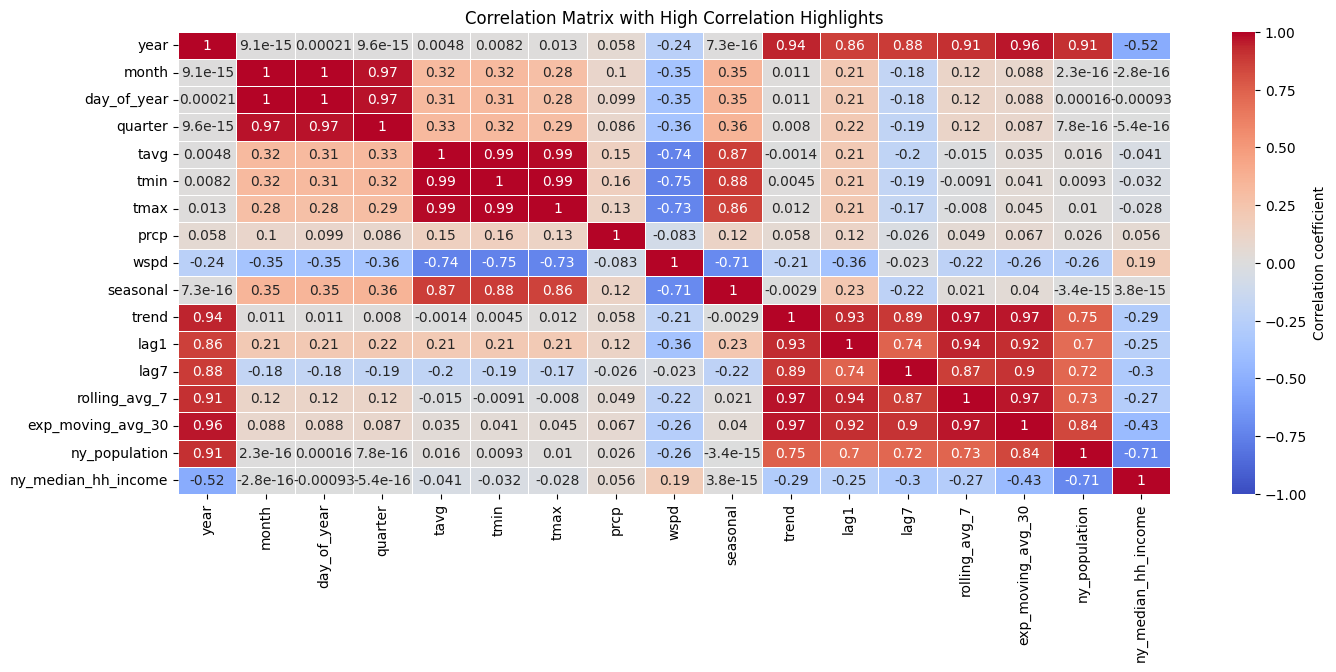

In [175]:
# Compute correlation matrix for features
corr_matrix = merged_data_train.corr()

# Create a heatmap with color highlighting for high correlation values
plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, linewidths=0.5, cbar_kws={'label': 'Correlation coefficient'})

# Show plot
plt.title('Correlation Matrix with High Correlation Highlights')
plt.show()

In [176]:
merged_data_train.isna().sum()

year                   0
month                  0
day_of_year            0
quarter                0
tavg                   0
tmin                   0
tmax                   0
prcp                   0
wspd                   0
seasonal               0
trend                  6
lag1                   1
lag7                   7
rolling_avg_7          6
exp_moving_avg_30      0
ny_population          0
ny_median_hh_income    0
dtype: int64

In [292]:
## Backfill columns with missing values - they are either lag features or moving averages
merged_data_train = merged_data_train.bfill()

### Correlation of features with target variable

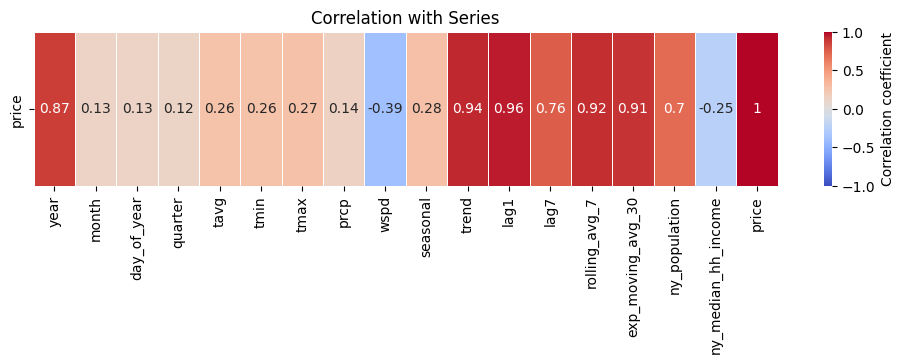

In [178]:
#correlation = merged_data_train[['year']].corrwith(y_train.reset_index().drop('date', axis=1))
# Reshape the correlation result for heatmap (1 row, n columns)
corr_matrix =  merged_data_train.merge(y_train.reset_index().drop('date', axis=1), left_index=True, right_index=True).corr()['price'].to_frame().T  # Transpose to have one row

# Plot the heatmap
plt.figure(figsize=(12, 2))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, linewidths=0.5, cbar_kws={'label': 'Correlation coefficient'})

# Show plot
plt.title('Correlation with Series')
plt.show()

## Feature Selection
* Drop t_min and t_max due to high multicollinearity with t_avg

#### Use Feature Importance method of XGBoost

In [179]:
model_importance = XGBRegressor()
model_importance.fit(merged_data_train, y_train)
importances = model_importance.feature_importances_

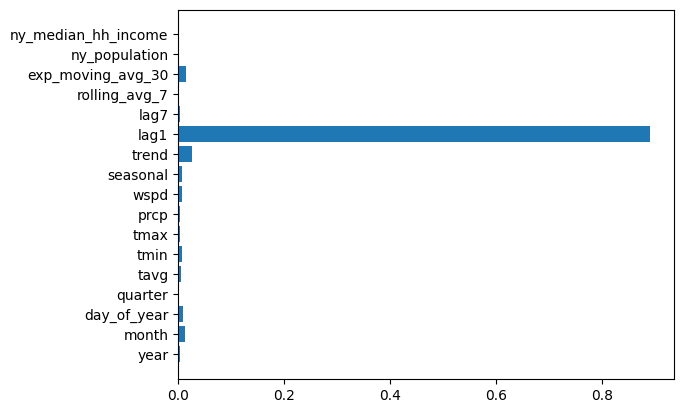

In [180]:
#Visualize importance
plt.barh(merged_data_train.columns, importances)
plt.show()

### Use SelectKBest on larger dataset with external variables

In [181]:
from sklearn.feature_selection import SelectKBest, f_regression
k_best = SelectKBest(score_func=f_regression, k=10)
X_new = k_best.fit_transform(merged_data_train, y_train)  # X: Features, y: Target
scores = k_best.scores_
selected_indices = k_best.get_support(indices=True)
selected_features = merged_data_train.columns[selected_indices]
selected_features

Index(['year', 'tmax', 'wspd', 'seasonal', 'trend', 'lag1', 'lag7',
       'rolling_avg_7', 'exp_moving_avg_30', 'ny_population'],
      dtype='object')

In [182]:
X_train_ext_var = merged_data_train.loc[:, selected_features]
y_train_ext_var = y_train.reset_index().drop(['date'], axis=1)

In [222]:
X_test_ext_var = merged_data_test.loc[:, selected_features]

# Train Models

### XGBoost Without External Data

In [293]:
X_train = X_train.bfill()

In [294]:
X_train

,day_of_year,month,quarter,year,seasonal,trend,lag1,lag7,rolling_avg_7,exp_moving_avg_30
date,,,,,,,,,,
2001-01-01,1,1,1,2001,0.965665,13.968333,13.89,13.89,14.035714,13.890000
2001-02-01,32,2,1,2001,0.985901,13.968333,13.89,13.89,14.035714,13.892581
2001-03-01,60,3,1,2001,0.962637,13.968333,13.93,13.89,14.035714,13.872414
2001-04-01,91,4,2,2001,0.969564,13.968333,13.58,13.89,14.035714,13.844516
2001-05-01,121,5,2,2001,1.000255,13.968333,13.44,13.89,14.035714,13.855193
...,...,...,...,...,...,...,...,...,...,...
2014-08-01,213,8,3,2014,1.030388,19.954167,20.48,19.57,20.512857,19.204796
2014-09-01,244,9,3,2014,1.039024,19.790833,19.51,21.69,20.187143,19.218035
2014-10-01,274,10,4,2014,1.021523,19.632500,19.41,20.90,19.977143,19.231710


In [296]:
model = XGBRegressor()
cv_split = TimeSeriesSplit(n_splits=3, test_size=48)

parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000]
}
grid_search_xgb1 = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search_xgb1.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=48),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impor...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

#### Predicting on Train Set

In [298]:
xgb_prediction_train = grid_search_xgb1.predict(X_train)

### Prediction on Test Set: Since we are using lag and rolling features, we must be careful about avoiding data leakage into the test set. The key is to ensure that all features in the test set are computed using only past information available at the time of prediction.

### Preparing Test Set Features Dynamically:

In [192]:
def update_decomposition(historical_data):
    # Combine historical data and the current test point
# Decompose using only available data
    decomposition = seasonal_decompose(historical_data['price'].iloc[:-1], model='additive', period=12, extrapolate_trend='freq')
    
    # Extract components for the test point
    trend = decomposition.trend.iloc[-1]  # Last available trend value
    seasonal = decomposition.seasonal.iloc[-1]  # Last seasonal value
    return trend, seasonal

In [280]:
def predict_on_test_set(model, X_test, X_train, y_train):
    for i in range(len(X_test)):
        # Access historical data
        historical_data = pd.concat([X_train.merge(y_train, how = 'inner', left_index=True, right_index=True), X_test.iloc[:i]])

        test_point = X_test.iloc[i:i+1, :]
        # Compute lag and rolling features for the current test point
        test_point.loc[:,'lag1'] = historical_data['price'].iloc[-1]
        test_point.loc[:,'lag7'] = historical_data['price'].iloc[-7]
        test_point.loc[:,'rolling_avg_7'] = historical_data['price'].iloc[-7:].mean()
        test_point.loc[:,'exp_moving_avg_30'] = historical_data['price'].rolling(window=30, min_periods=1).apply(
        lambda x: x.ewm(span=ema_window, adjust=False).mean().iloc[-1], raw=False).iloc[-1]
    
        #Compute seasonal and trend features for the current test point
        trend, seasonal = update_decomposition(historical_data)
        test_point.loc[:,'trend'] = trend
        test_point.loc[:,'seasonal'] = seasonal
        
        # Predict using the trained model
        # Use the trained model to predict for the single row
        prediction = model.predict(test_point)
        
        # Store the prediction in the test dataframe as the price for that row
        historical_data.iloc[i, -1] = prediction

    return historical_data.iloc[len(X_train):, -1]

In [281]:
def evaluate_model(y_train, train_predictions, y_test, test_predictions):
    # Calculate metrics for train set
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    train_mape = mean_absolute_percentage_error(y_train, train_predictions)
    
    # Calculate metrics for test set
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mape = mean_absolute_percentage_error(y_test, test_predictions)
    
    # Create a dataframe to display metrics
    metrics_df = pd.DataFrame({
        'Metric': ['MAE', 'MSE', 'MAPE'],
        'Train': [train_mae, train_mse, train_mape],
        'Test': [test_mae, test_mse, test_mape]
    })

    # Set 'Metric' as the index
    metrics_df.set_index('Metric', inplace=True)
    
    # Display the table
    print(metrics_df)
    return metrics_df

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

In [300]:
X_train, X_test

(            day_of_year  month  quarter  year  seasonal      trend   lag1  \
 date                                                                        
 2001-01-01            1      1        1  2001  0.965665  13.968333  13.89   
 2001-02-01           32      2        1  2001  0.985901  13.968333  13.89   
 2001-03-01           60      3        1  2001  0.962637  13.968333  13.93   
 2001-04-01           91      4        2  2001  0.969564  13.968333  13.58   
 2001-05-01          121      5        2  2001  1.000255  13.968333  13.44   
 ...                 ...    ...      ...   ...       ...        ...    ...   
 2014-08-01          213      8        3  2014  1.030388  19.954167  20.48   
 2014-09-01          244      9        3  2014  1.039024  19.790833  19.51   
 2014-10-01          274     10        4  2014  1.021523  19.632500  19.41   
 2014-11-01          305     11        4  2014  0.990901  19.451250  19.43   
 2014-12-01          335     12        4  2014  0.962397  19.257

In [299]:
xgb_prediction_test = predict_on_test_set(grid_search_xgb1, X_test, X_train, y_train)

ValueError: This function does not handle missing values

In [278]:
xgb_prediction_test.shape

(59,)

In [279]:
metrics_df_xgb1 = evaluate_model(y_train, xgb_prediction_train, y_test, xgb_prediction_test)

ValueError: Found input variables with inconsistent numbers of samples: [60, 59]

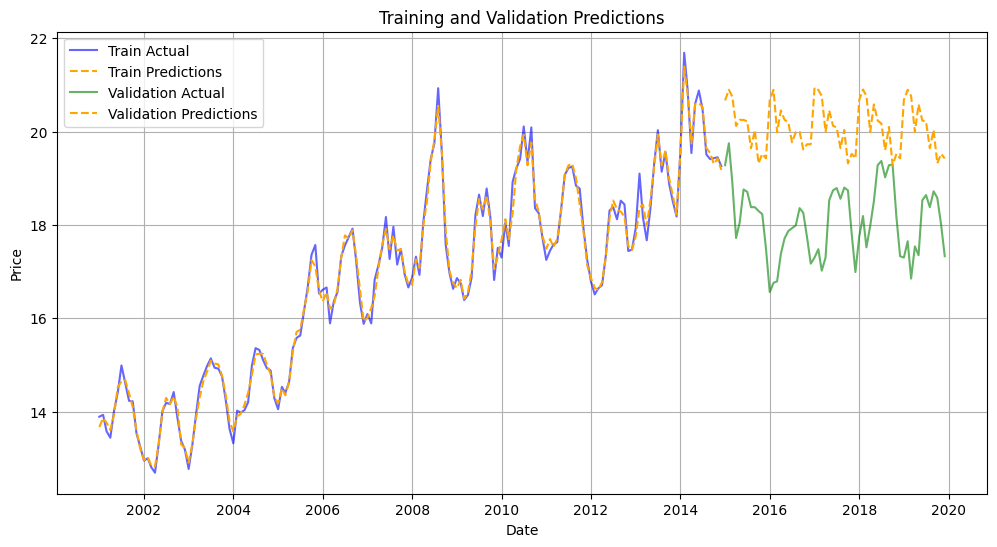

In [215]:
def plot_combined_predictions(train_dates, y_train, train_predictions, 
                               test_dates, y_test, test_predictions):
    plt.figure(figsize=(12, 6))

    # Plot training data and predictions
    plt.plot(train_dates, y_train, label='Train Actual', color='blue', alpha=0.6)
    plt.plot(train_dates, train_predictions, label='Train Predictions', color='orange', linestyle='--')

    # Plot validation data and predictions
    plt.plot(test_dates, y_test, label='Validation Actual', color='green', alpha=0.6)
    plt.plot(test_dates, test_predictions, label='Validation Predictions', color='orange', linestyle='--')

    # Customize the plot
    plt.title('Training and Validation Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
plot_combined_predictions(
    train_dates, list(y_train), xgb_prediction_train, 
    test_dates, list(y_test), xgb_prediction_test
)

### XGBoost With External Data Incorporated

In [218]:
model_xgb_w = XGBRegressor()
cv_split = TimeSeriesSplit(n_splits=3, test_size=48)

parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000]
}
grid_search_xgb_w = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search_xgb_w.fit(X_train_ext_var, y_train_ext_var)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=48),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impor...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

In [227]:
xgb_prediction_train_w = grid_search_xgb_w.predict(X_train_ext_var)

In [237]:
X_test_ext_var.columns,  X_train_ext_var.columns

(Index(['year', 'tmax', 'wspd', 'seasonal', 'trend', 'lag1', 'lag7',
        'rolling_avg_7', 'exp_moving_avg_30', 'ny_population'],
       dtype='object'),
 Index(['year', 'tmax', 'wspd', 'seasonal', 'trend', 'lag1', 'lag7',
        'rolling_avg_7', 'exp_moving_avg_30', 'ny_population'],
       dtype='object'))

In [255]:
xgb_prediction_test_w = predict_on_test_set(grid_search_xgb_w, X_test_ext_var, X_train_ext_var, y_train_ext_var)['price'] 

Empty DataFrame
Columns: [year, tmax, wspd, seasonal, trend, lag1, lag7, rolling_avg_7, exp_moving_avg_30, ny_population, price]
Index: []
Empty DataFrame
Columns: [year, tmax, wspd, seasonal, trend, lag1, lag7, rolling_avg_7, exp_moving_avg_30, ny_population, price]
Index: []
Empty DataFrame
Columns: [year, tmax, wspd, seasonal, trend, lag1, lag7, rolling_avg_7, exp_moving_avg_30, ny_population, price]
Index: []
Empty DataFrame
Columns: [year, tmax, wspd, seasonal, trend, lag1, lag7, rolling_avg_7, exp_moving_avg_30, ny_population, price]
Index: []
Empty DataFrame
Columns: [year, tmax, wspd, seasonal, trend, lag1, lag7, rolling_avg_7, exp_moving_avg_30, ny_population, price]
Index: []
Empty DataFrame
Columns: [year, tmax, wspd, seasonal, trend, lag1, lag7, rolling_avg_7, exp_moving_avg_30, ny_population, price]
Index: []
Empty DataFrame
Columns: [year, tmax, wspd, seasonal, trend, lag1, lag7, rolling_avg_7, exp_moving_avg_30, ny_population, price]
Index: []
Empty DataFrame
Columns: [y

In [250]:
xgb_prediction_test_w

0     19.255013
1     20.627682
2     20.505264
3     20.159685
4     20.248512
5     20.457710
6     20.500217
7     20.192404
8     20.230846
9     20.078228
10    20.174334
11    20.239311
12    20.125299
13    20.751970
14    20.578190
15    20.196632
16    20.141996
17    20.250372
18    20.147486
19    20.184616
20    20.184616
21    20.143530
22    20.251467
23    20.095064
24    20.616917
25    20.743673
26    20.368002
27    20.183872
28    20.247274
29    20.224554
30    20.006811
31    20.184616
32    20.362968
33    20.333517
34    20.319628
35    20.095064
36    20.756008
37    20.758352
38    20.352041
39    20.183872
40    20.172844
41    20.318699
42    20.154057
43    20.181622
44    20.184616
45    20.305376
46    20.164759
47    20.325218
48    20.605013
49    20.719915
50    20.705236
51    20.279282
52    20.150509
53    20.191919
54    20.074778
55    20.035210
56    19.558750
57    20.147329
58    20.042013
59    20.280231
Name: price, dtype: float32

In [251]:
metrics_df_xgb_w = evaluate_model( y_train, xgb_prediction_train_w,  y_test, xgb_prediction_test_w)

           Train      Test
Metric                    
MAE     0.074179  2.183083
MSE     0.010266  5.499298
MAPE    0.004396  0.122795


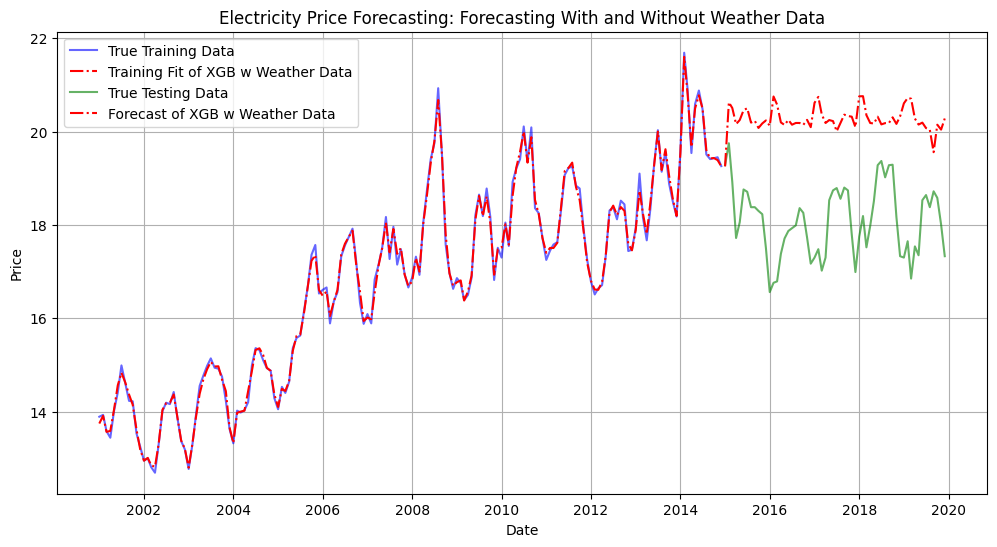

In [252]:
plt.figure(figsize=(12, 6))

# Plot training data and predictions
plt.plot(train_dates, y_train, label='True Training Data', color='blue', alpha=0.6)
plt.plot(train_dates, xgb_prediction_train_w, label='Training Fit of XGB w Weather Data', color='red', linestyle='-.')

# Plot validation data and predictions
plt.plot(test_dates, y_test, label='True Testing Data', color='green', alpha=0.6)
plt.plot(test_dates, xgb_prediction_test_w, label='Forecast of XGB w Weather Data', color='red', linestyle='-.')

# Customize the plot
plt.title('Electricity Price Forecasting: Forecasting With and Without Weather Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

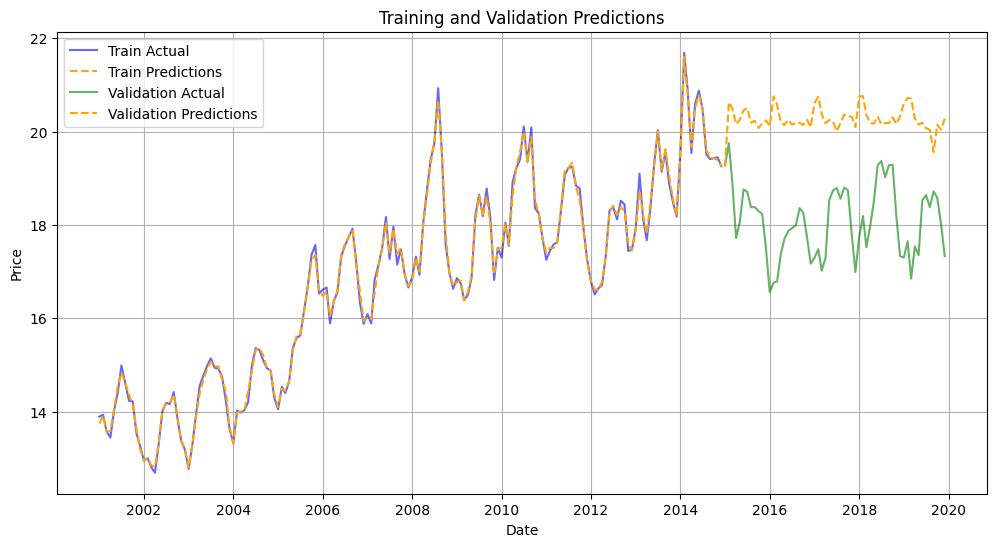

In [253]:
plot_combined_predictions(
    train_dates, list(y_train), xgb_prediction_train_w, 
    test_dates, list(y_test), xgb_prediction_test_w
)

#### Plot Combining Predictions of XGBoost without and with Weather Data

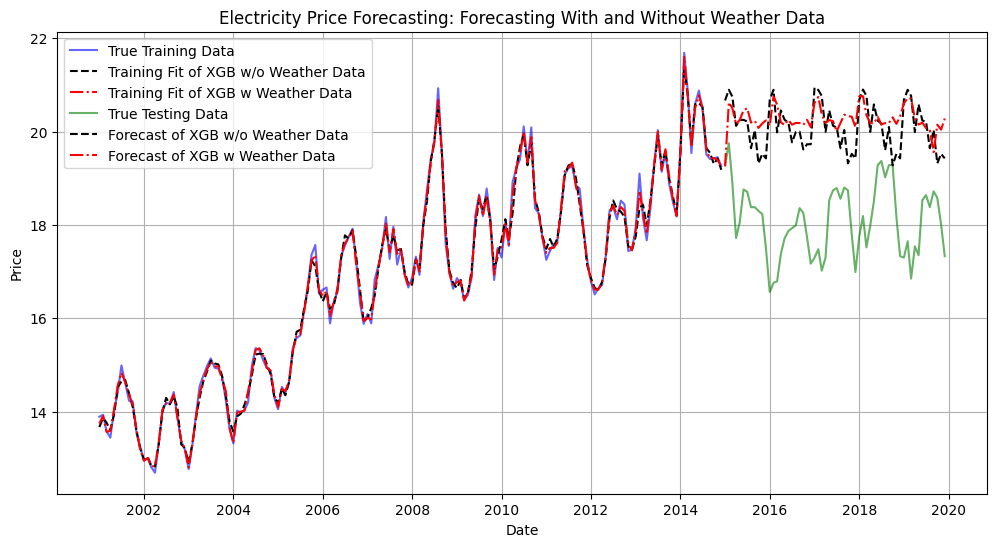

In [254]:
plt.figure(figsize=(12, 6))

# Plot training data and predictions
plt.plot(train_dates, y_train, label='True Training Data', color='blue', alpha=0.6)
plt.plot(train_dates, xgb_prediction_train, label='Training Fit of XGB w/o Weather Data', color='black', linestyle='--')
plt.plot(train_dates, xgb_prediction_train_w, label='Training Fit of XGB w Weather Data', color='red', linestyle='-.')

# Plot validation data and predictions
plt.plot(test_dates, y_test, label='True Testing Data', color='green', alpha=0.6)
plt.plot(test_dates, xgb_prediction_test, label='Forecast of XGB w/o Weather Data', color='black', linestyle='--')
plt.plot(test_dates, xgb_prediction_test_w, label='Forecast of XGB w Weather Data', color='red', linestyle='-.')

# Customize the plot
plt.title('Electricity Price Forecasting: Forecasting With and Without Weather Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
